#### Note to the reader -- 
Making a quick notebook to have workable code to analyse Navideh's data. I am going to attempt using HMMs to model the state transitions rate matrix that describes the wasting model. 
This work initially will contain a tutorial exercise from some guy on the internet. After understanding the key operational components of working with Markov models, I will then attempt to swap out the previous code tha contains simulated data with the data that is cleaned by her. 

In [19]:
# importing useful libraries
import numpy as np
import polars as pl
import altair as alt

import matplotlib.pyplot as plt
import seaborn as sns

import os

# bayesian pacakeges
import pymc as pm
import preliz as pz
import arviz as az

from scipy.stats import multinomial, norm, poisson, binom, beta, gamma, expon, uniform
from typing import List

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# setting the style of the plots
sns.set_style('ticks')
plt.style.use('dark_background')

sns.set_context("notebook")


As usual going to start by simulating data. 

### Transition matrix -- 
Keeping the dimensions of the model as 3 states to reflect unwasted, mam and sam. Naturally this model allows for bi-directional flows between theses states. 

In [20]:
# This is going to be a 3 state transition model.
p_transition_mat = np.array([[0.9, 0.05, 0.05], [0.01, 0.8, 0.19], [0.17, 0.03, 0.8]])

# calculate the rowsums = making sue the rows add up to a 1
assert np.allclose(p_transition_mat.sum(axis=1), [1.0, 1.0, 1.0])

# print out the transition matrix
p_transition_mat

array([[0.9 , 0.05, 0.05],
       [0.01, 0.8 , 0.19],
       [0.17, 0.03, 0.8 ]])

### Initial proportion of individuals
This assumes that we know or are going to infer the initial conditions of the population that we are studying. Non-equilibrium dynamics. 

In [21]:
init = np.array([0.9, 0.05, 0.05])

# make sure the initial state probabilities add up to 1
assert np.allclose(init.sum(), 1.0)

In [22]:
# Simple simulation of states given these initial conditions and state transition matrix
n_steps = 200
p_state_t = np.zeros((n_steps, 3))

# initialize these states with init
p_state_t[0] = init

for t in range((n_steps - 1)):
    p_state_t[t + 1] = p_state_t[t] @ (p_transition_mat)

assert np.allclose(p_state_t.sum(axis=1), 1.0)

In [23]:
p_state = pl.DataFrame(
    p_state_t, schema={"unwasted": pl.Float64, "mam": pl.Float64, "sam": pl.Float64}
)
p_state.head()

unwasted,mam,sam
f64,f64,f64
0.9,0.05,0.05
0.819,0.0865,0.0945
0.75403,0.112985,0.132985
0.702364,0.132079,0.165557
0.661593,0.145748,0.192659


<Axes: >

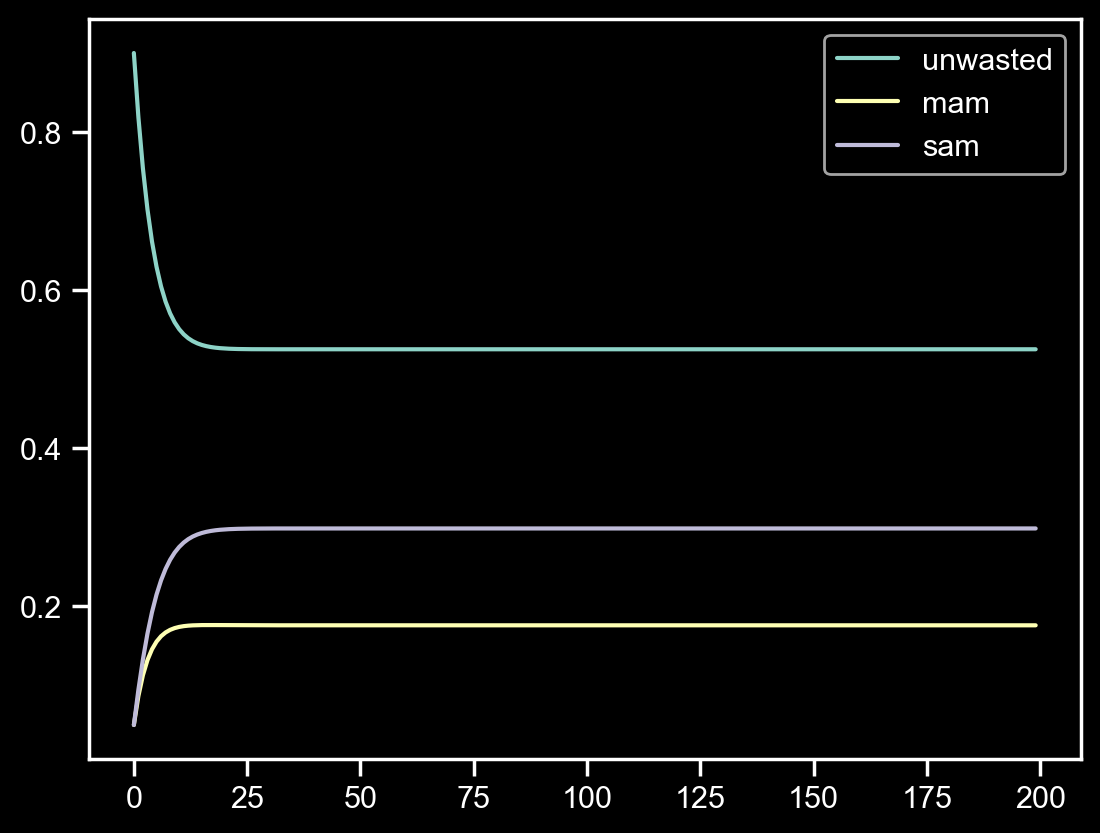

In [24]:
# Convert polars.DataFrame to pandas.DataFrame
p_state_pd = p_state.to_pandas()

# Plot the data
p_state_pd.plot()

# p_state.tail(1)

In [25]:
# alternative to the above the
def equilibrium_distribution(p_transition: np.ndarray) -> np.ndarray:
    """This implementation comes from Colin Carroll, who kindly reviewed the notebook"""
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0,
    )
    # Moore-Penrose pseudoinverse = (A^TA)^{-1}A^T
    pinv = np.linalg.pinv(A)
    # Return last row
    return pinv.T[-1]


equilibrium_distribution(p_transition_mat)

array([0.52526799, 0.17611026, 0.29862175])

In [26]:
# This is the same as the last row of the transition matrix raised to a large power
def markov_sequence(p_init: np.ndarray, p_transition: np.ndarray, n_steps: int) -> List:
    """
    Generate the Markov sequence of statesbased on init and p_transition
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)

    # genearete the initial state
    initial_state = list(multinomial.rvs(1, p_init)).index(1)
    # make sure the time and states are the same length
    time = list(range(n_steps + 1))
    states = [initial_state]
    for _ in range(n_steps):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)

    return states, time

In [27]:
# plot the states over time
states, _ = markov_sequence(init, p_transition_mat, 1000)

Text(0.5, 1.0, 'State sequence over time')

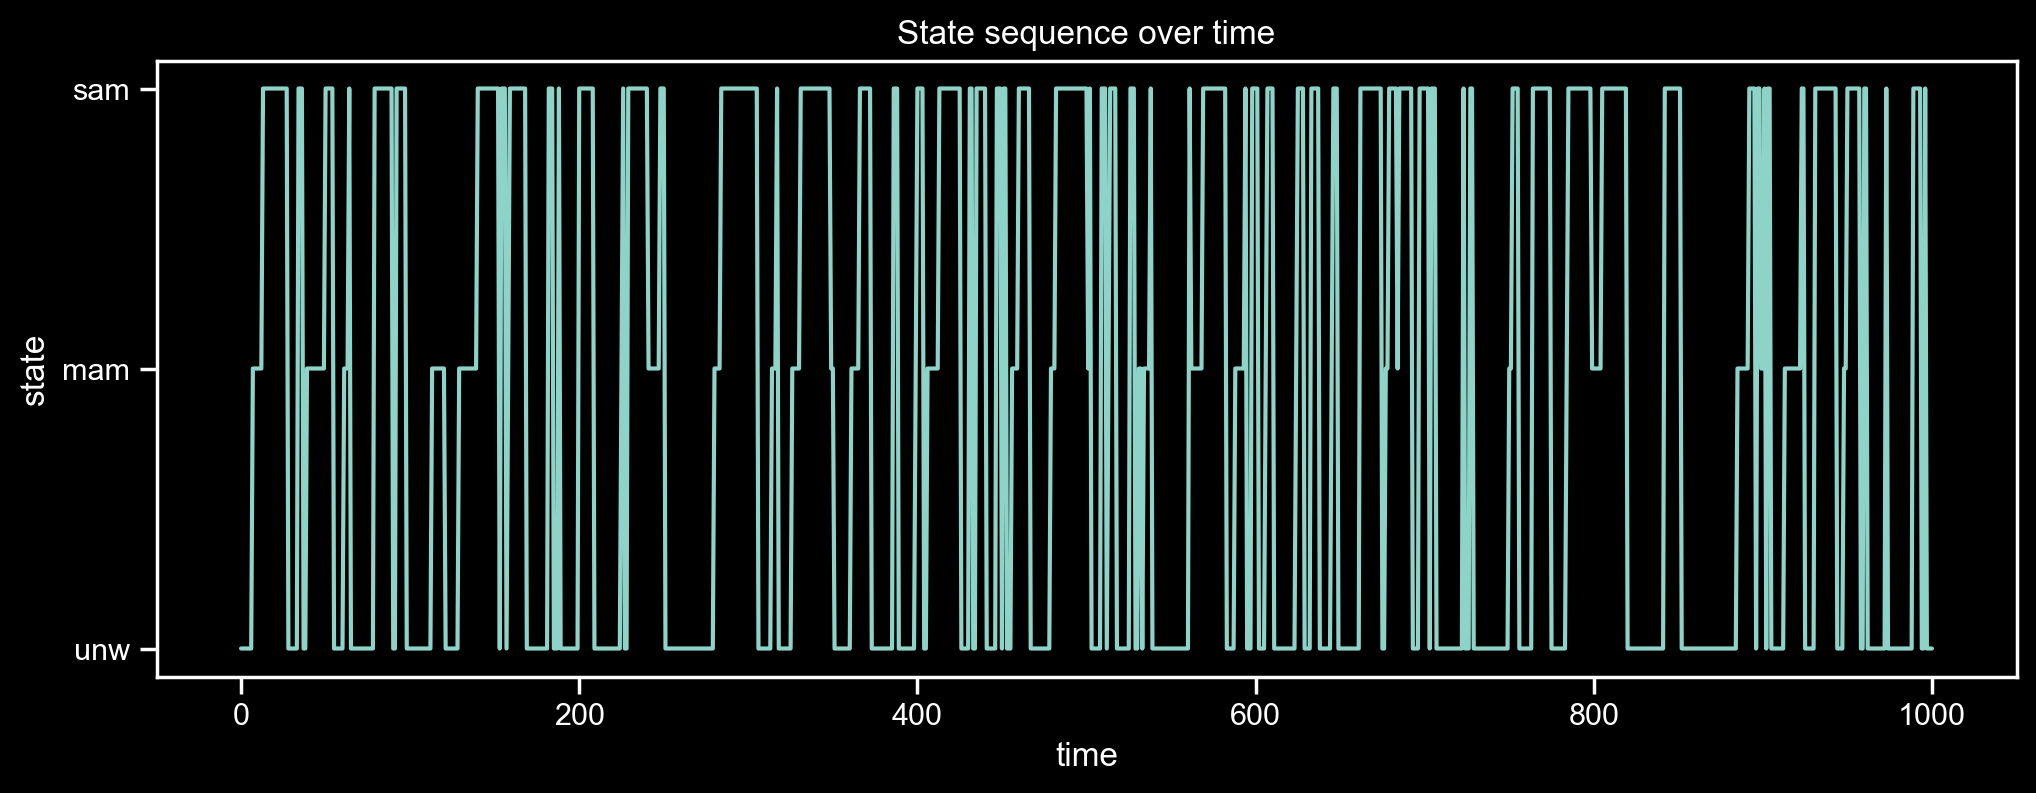

In [28]:
fig, axs = plt.subplots(figsize=(12, 4))
plt.plot(states)
plt.xlabel("time")
plt.ylabel("state")
plt.yticks([0, 1, 2], ["unw", "mam", "sam"])
plt.title("State sequence over time")

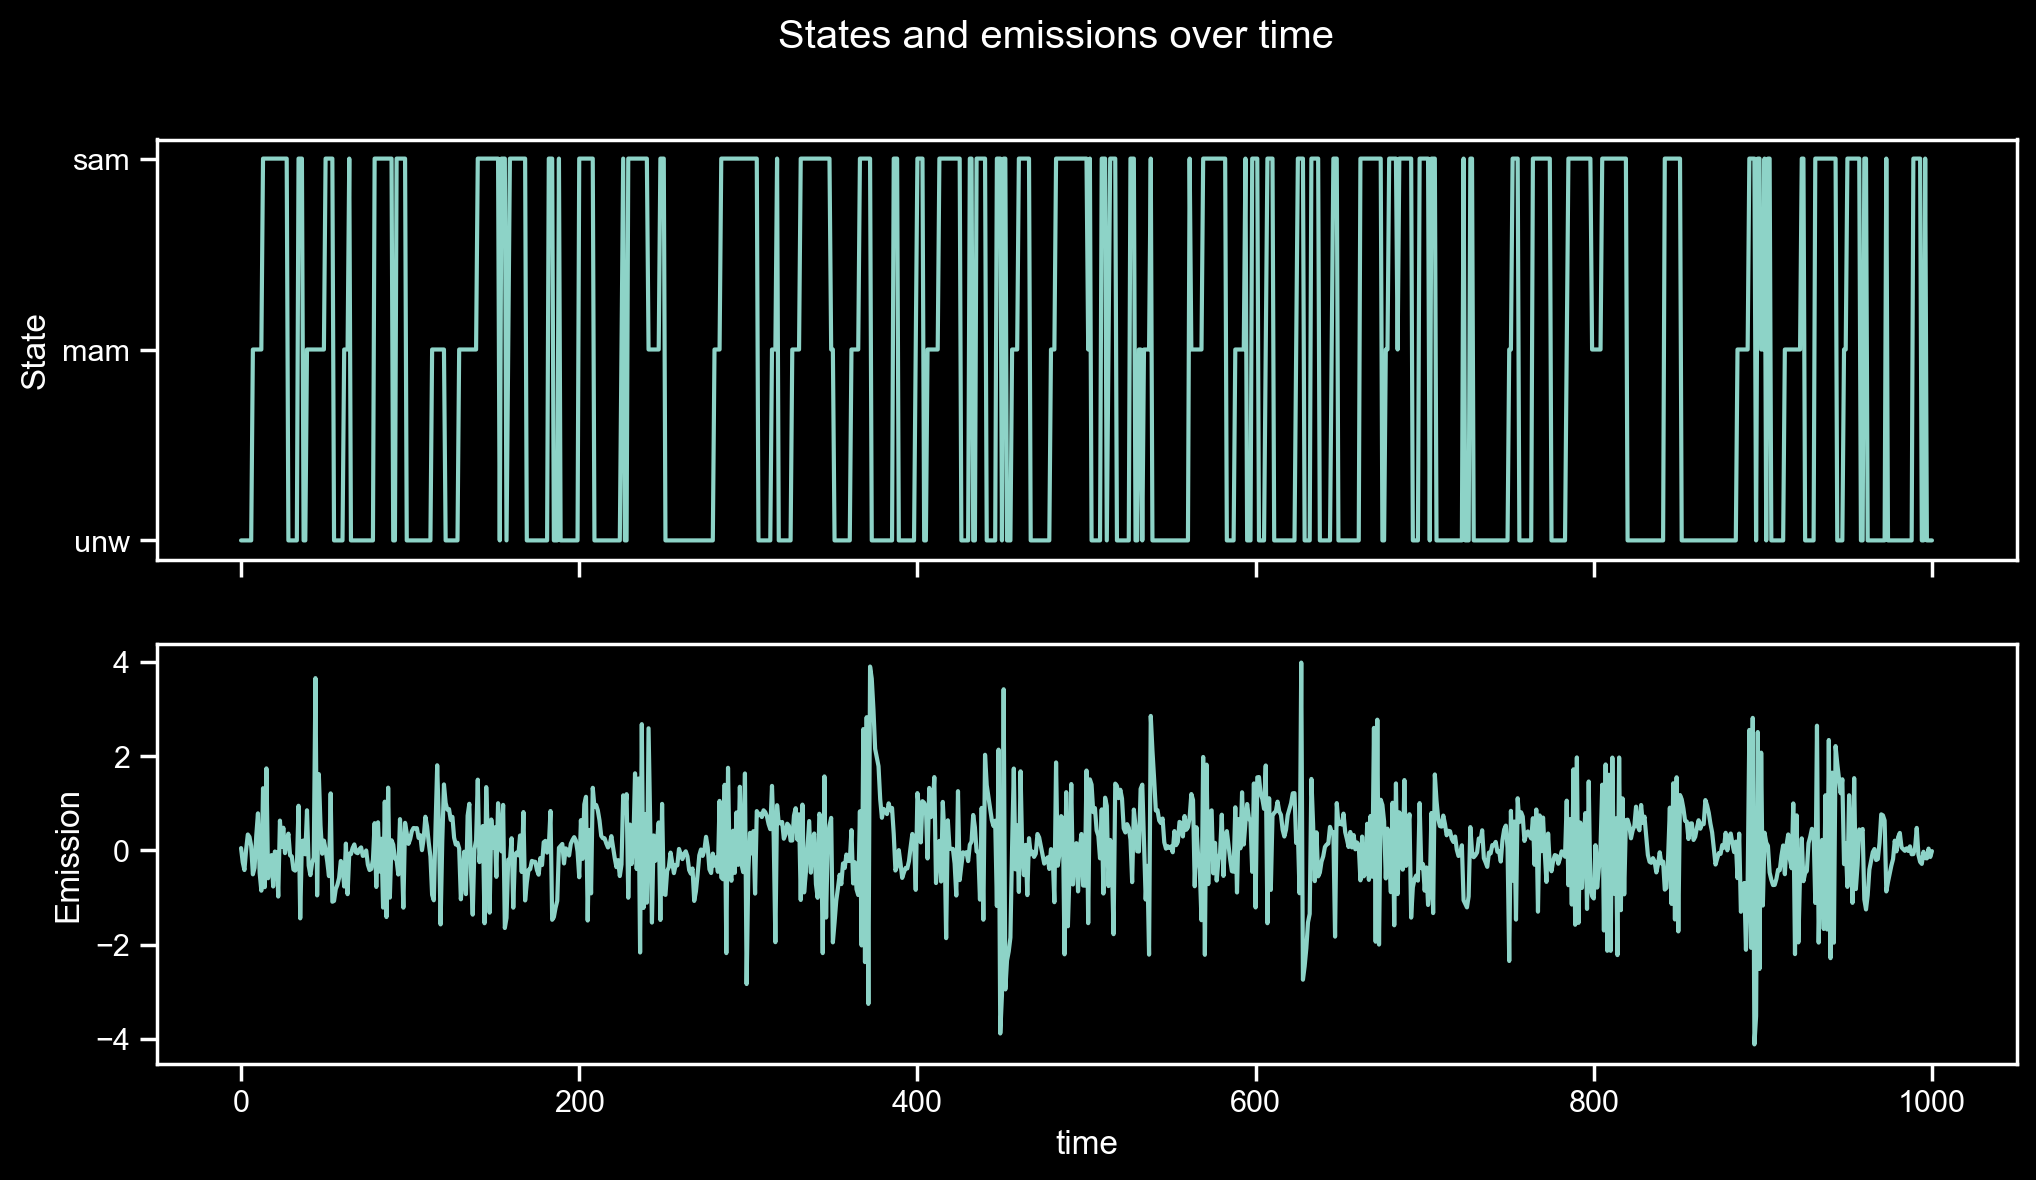

In [29]:
# modeling emissions
def gaussian_emission(
    states: List[int], mus: List[float], sigmas: List[float]
) -> List[float]:
    emissions = []
    prev_emit = 0
    for state in states:
        loc = mus[state]
        scale = sigmas[state]
        e = norm.rvs(loc=prev_emit * loc, scale=scale)
        prev_emit = e
        emissions.append(e)
    return emissions


gaussian_ems = gaussian_emission(states, mus=[0.8, 0, -0.8], sigmas=[0.2, 1, 0.8])


def plot_emissions(states: List[int], emissions: List[float]):
    fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=1, sharex=True)
    axs[0].plot(states, label="states")
    axs[0].set_ylabel("State")
    axs[0].set_yticks([0, 1, 2])
    axs[0].set_yticklabels(["unw", "mam", "sam"])
    axs[1].plot(emissions, label="emissions")
    axs[1].set_ylabel("Emission")
    plt.xlabel("time")
    fig.suptitle("States and emissions over time")


plot_emissions(states, gaussian_ems)

### Simulating individual data
Now going forward and generating some individual data since the actual data set contains individuals being tracked through time. 

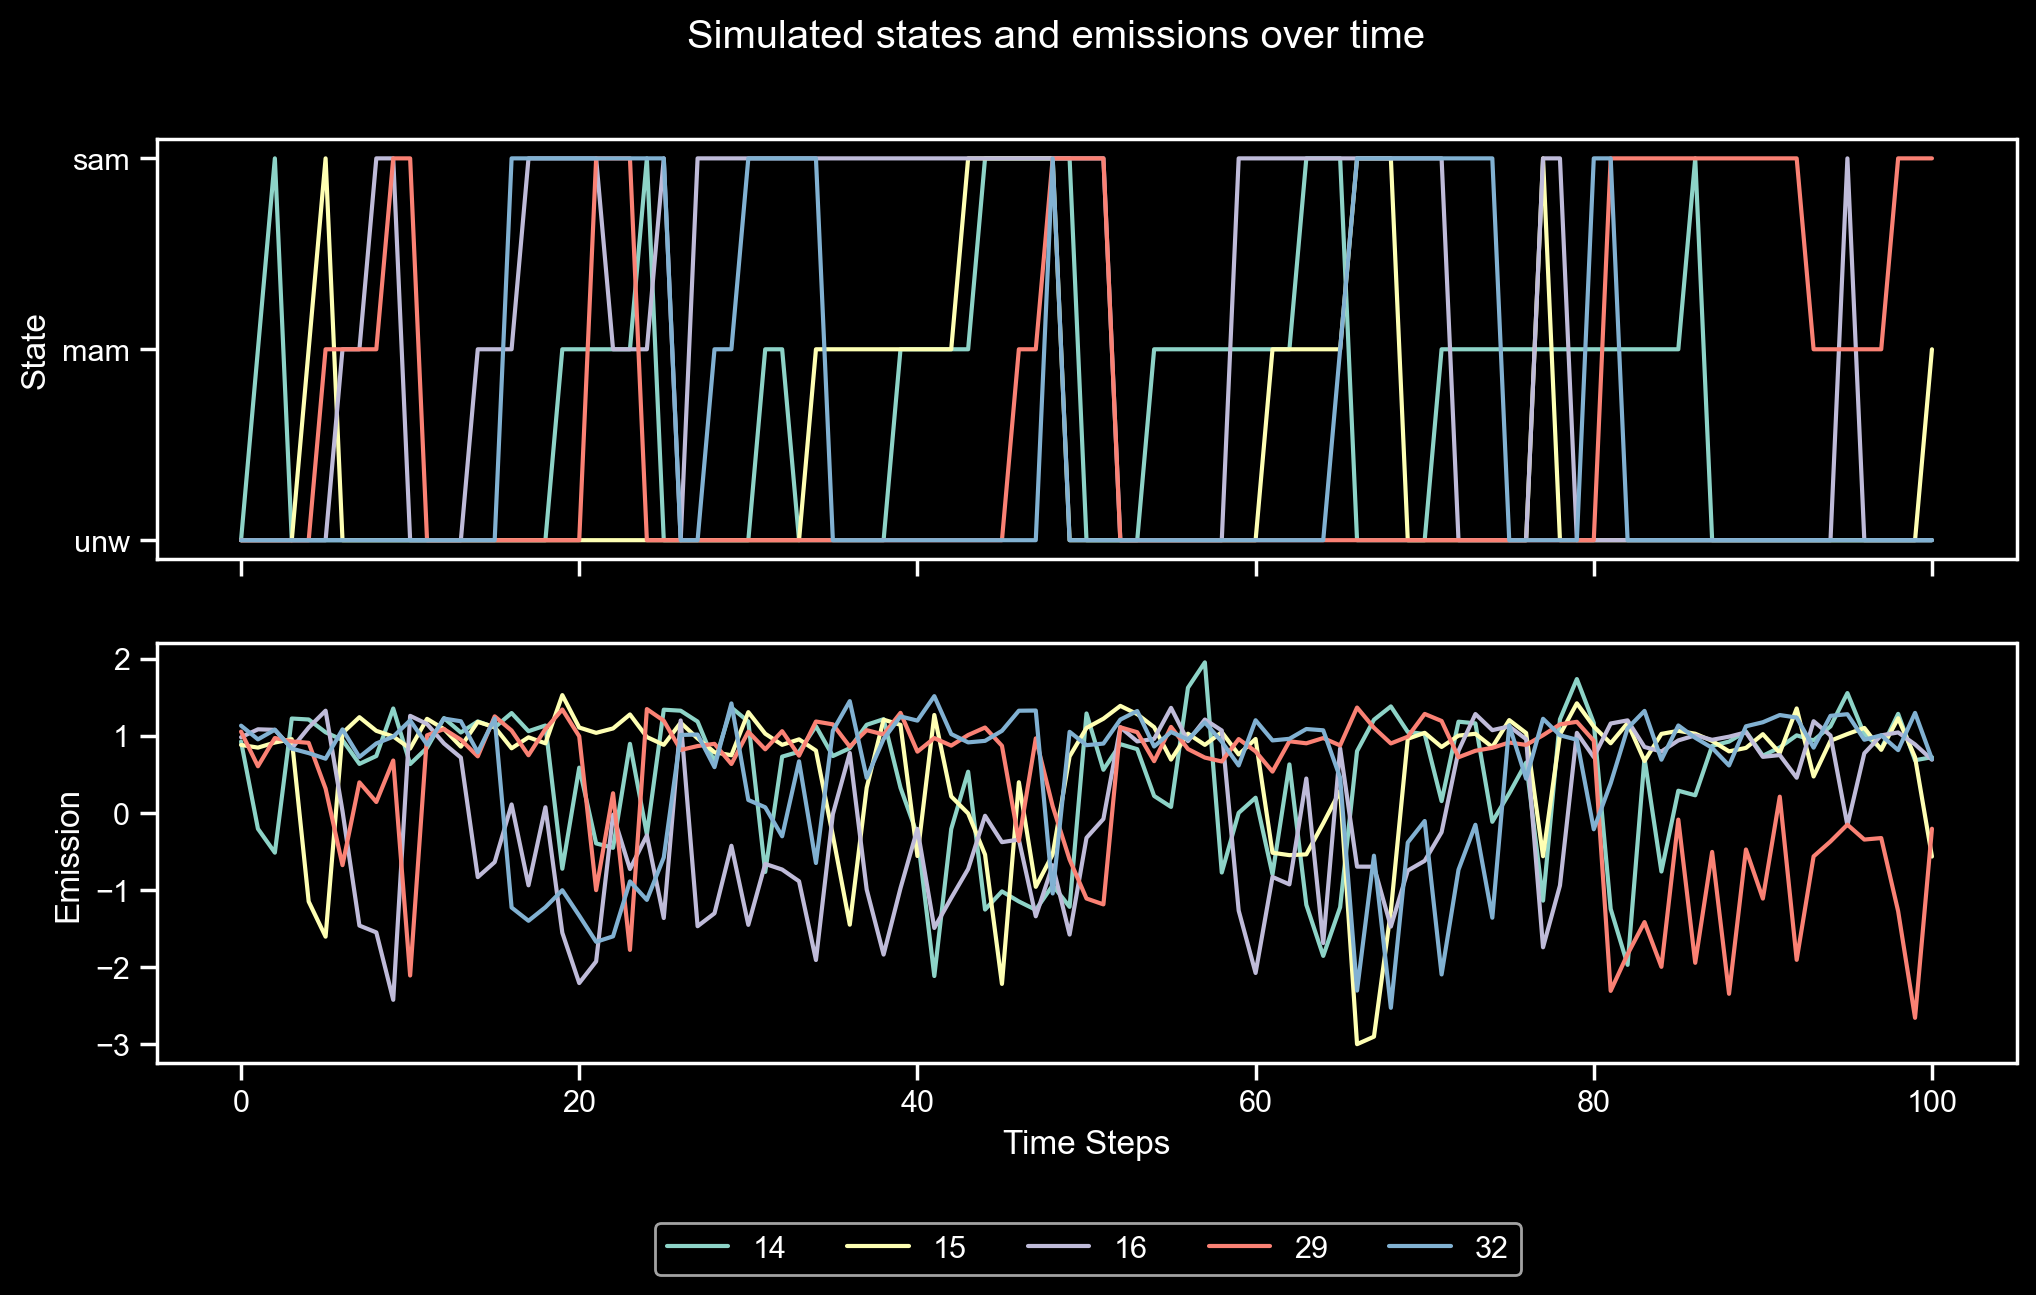

In [18]:
np.random.seed(42)
# lets simulate multiple individuals and store them in a dataframe
n_individuals = 100
n_steps = 100
simulated_data = []
for i, t in enumerate(range(n_individuals)):
    states, time = markov_sequence(init, p_transition_mat, n_steps)
    emissions = gaussian_emission(states, mus=[1, 0, -1], sigmas=[0.2, 1, 0.8])
    simulated_data.append(
        pl.DataFrame({"id": i, "time": time, "states": states, "emissions": emissions})
    )

simulated_df = pl.concat(simulated_data)

# choose 10 individuals at random between 0 and 100
ind_subset = list(np.random.choice(range(100), 5))

# subset from the simulated data for plotting
simulated_df_plt = simulated_df.filter(pl.col("id").is_in(ind_subset)).with_columns(
    pl.col("id").cast(pl.Utf8).cast(pl.Categorical)
)

# plot the simulated data
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=1, sharex=True)
sns.lineplot(
    data=simulated_df_plt, x="time", y="states", hue="id", ax=axs[0], legend=True
)
axs[0].set_ylabel("State")
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels(["unw", "mam", "sam"])
sns.lineplot(
    data=simulated_df_plt, x="time", y="emissions", hue="id", ax=axs[1], legend=False
)
axs[1].set_ylabel("Emission")
plt.xlabel("Time Steps")
fig.suptitle("Simulated states and emissions over time")

# Create a common legend and remove legend from the first plot
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend_.remove()
fig.legend(handles, labels, bbox_to_anchor=(0.7, -0.01), ncol=5)

### Likelihood for HMM and MM models -- 
Likelihood of the given Markov chain is given as -- 

For a Markov chain given by a sequence $S = \{s_1, s_2, s3, ..., s_N\}$ given by an initial state distribution $s_0$, where $s_i$ is the state of the system at time step $i \in \{1, 2, \dots N\}$ is given by:

$L(S) = P(s_0)P(s_1|s_0)P(s_2|s_1) \dots P(s_{N}|s_{N-1})$

Going to start with some maual labor. 

In [30]:
# manually calculating each probability of the state given the previous state for the first two values--
print(p_transition_mat)
print("-----")
print(init)
print("-----")
print(equilibrium_distribution(p_transition_mat))

# for a state that s1
s1 = [0, 1, 0]  # start in state 1
p_eq = equilibrium_distribution(p_transition_mat)
prob_s1 = p_eq[s1.index(1)]
print(prob_s1)
print("-----")
# for a state that s2
s2 = [0, 0, 1]  # start in state 2
transition_entry = p_transition_mat[s1.index(1)]
prob_s2 = transition_entry[s2.index(1)]
print(prob_s2)
print("-----")
# joint likelihood of the first two states
joint_prob = prob_s1 * prob_s2
print(joint_prob)
print("-----")
# log likelihood of the first two states
log_joint_prob = np.log(joint_prob)
print(log_joint_prob)
print("-----")

[[0.9  0.05 0.05]
 [0.01 0.8  0.19]
 [0.17 0.03 0.8 ]]
-----
[0.9  0.05 0.05]
-----
[0.52526799 0.17611026 0.29862175]
0.17611026033690652
-----
0.19
-----
0.03346094946401224
-----
-3.397376207734832
-----


In [31]:
# write a function to calculate the log likelihood of the states
# dprocess
# estimating the initial state distributions
def initial_state_logp(p_transition_mat, states):
    initial_states = states[0]
    states_oh = np.eye(len(p_transition_mat))
    eq_probs = equilibrium_distribution(p_transition_mat)
    return multinomial(n=1, p=eq_probs).logpmf(states_oh[initial_states]).squeeze()


# estimating the state transition likelihood
def state_logp(p_transition_mat, states):
    # one hot code the states
    states_oh = np.eye(len(p_transition_mat))
    # get the transition probabilities for subsequent states
    p_tr = p_transition_mat[states[:-1]]
    # define the observations based on the oh_states
    obs = states_oh[states[1:]]
    return np.sum(multinomial(n=1, p=p_tr).logpmf(obs))


# total log likelihood of the states
def markov_state_logp(p_transition_mat, states):
    init_logp_val = initial_state_logp(p_transition_mat, states)
    state_logp_val = state_logp(p_transition_mat, states)
    loglik = init_logp_val + state_logp_val
    return loglik


# finally generate the likelihood function for the emissions
# dmeasure
def emission_logp(states, emissions, mus, sigmas):
    mu = mus[states]
    sigma = sigmas[states]
    return np.sum(norm.logpdf(emissions, loc=mu, scale=sigma))


# joint log likelihood of the states and emissions
def joint_logp(p_transition_mat, states, emissions, mus, sigmas):
    state_logp_val = markov_state_logp(p_transition_mat, states)
    emission_logp_val = emission_logp(states, emissions, mus, sigmas)
    return state_logp_val + emission_logp_val

### Loglikelihood using "Jax" 

Since there isnt a built-in likelihood for a hidden markov state model, I am making use of a theano specifiucation of likelihood.  

In [51]:
# loading some more libraries down here
import pytensor.tensor as pt

In [47]:
with pm.Model() as hmm_vec_model:
    # Priors (shared across all individuals)
    p_initial = pm.Dirichlet("p_initial", a=np.ones(n_states))
    p_transition = pm.Dirichlet(
        "p_transition", a=np.ones((n_states, n_states)), shape=(n_states, n_states)
    )

    # Log-prob of s_0 for each individual
    logp0 = pt.log(p_initial)[states[:, 0]]  # shape (N,)

    # Log-probs of transitions
    prev_states = states[:, :-1]  # shape (N, T-1)
    curr_states = states[:, 1:]  # shape (N, T-1)

    # Log-transitions shape: (n_states, n_states)
    logp_transition_matrix = pt.log(p_transition)

    # Use fancy indexing: we get a (N, T-1) matrix of log-probs
    logps = logp_transition_matrix[prev_states, curr_states]  # shape (N, T-1)

    # Total log-likelihood per individual
    total_logp_per_individual = logp0 + pt.sum(logps, axis=1)  # shape (N,)

    # Final log-likelihood
    total_logp = pt.sum(total_logp_per_individual)

    # Add to model
    pm.Potential("markov_loglike", total_logp)

    # Sample!
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

Unjaxed loglik: -511.4423383295023


ImportError: cannot import name 'shard_map' from 'jax.experimental' (/opt/miniconda3/envs/bap/lib/python3.11/site-packages/jax/experimental/__init__.py)


You can find the C code in this temporary file: /var/folders/hh/h4xmxbls6sb90qzd46r5fqdc0000gn/T/theano_compilation_error_hvscb3as


Exception: Compilation failed (return status=1): In file included from /Users/devengokhale/.theano/compiledir_macOS-15.3.2-arm64-arm-64bit-arm-3.11.6-64/lazylinker_ext/mod.cpp:1:. In file included from /opt/miniconda3/envs/bap/include/python3.11/Python.h:23:. In file included from /Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1/stdlib.h:87:. /Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1/__config:48:8: warning: "Libc++ only supports Clang 16 and later" [-W#warnings]. #      warning "Libc++ only supports Clang 16 and later".        ^. 1 warning generated.. dyld[9395]: Symbol not found: __ZNK4tapi2v119LinkerInterfaceFile28getPlatformsAndMinDeploymentEv.   Referenced from: <565CE761-C1EB-37F5-9738-E1BCF6F2EC75> /Library/Developer/CommandLineTools/usr/bin/ld.   Expected in:     <A6606D03-7848-3F9C-9EC0-321969BFB582> /opt/miniconda3/envs/bap/lib/libtapi.dylib. clang-15: error: unable to execute command: Abort trap: 6. clang-15: error: linker command failed due to signal (use -v to see invocation). 